# Hotel Cancellation Prediction - ANN part

In [1]:
from google.colab import drive
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

sns.set(style="darkgrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/myDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/myDrive


## 1. Read Data

In [3]:
############ Path Settings ############
data_path      = "/content/myDrive/My Drive/Hotel_Cancellation/data"
#######################################

df             = pd.read_csv(os.path.join(data_path, "hotel_bookings.csv"))
df_train_all   = pd.read_csv(os.path.join(data_path, "train.csv"))
df_test        = pd.read_csv(os.path.join(data_path, "test.csv"))

X_test_df      = df_test.iloc[:, :-1]
y_test         = df_test.iloc[:, -1].values

X_train_all_df = df_train_all.iloc[:, :-1]
y_train_all    = df_train_all.iloc[:, -1].values

X_train, X_val, y_train, y_val = train_test_split(X_train_all_df.values, y_train_all, test_size=0.25, stratify=y_train_all, random_state=1126)

X_train_df     = pd.DataFrame(X_train, columns=X_train_all_df.columns)

X_val_df       = pd.DataFrame(X_val, columns=X_train_all_df.columns)

print(X_train_df.values.shape, X_val_df.values.shape, X_test_df.values.shape)

(71634, 28) (23878, 28) (23878, 28)


## 2. Preprocessing

In [4]:
col_cat = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 
           'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'company', 'customer_type']
col_ord = ['arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month']
col_num = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 
           'previous_cancellations','previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list',
           'adr', 'required_car_parking_spaces', 'total_of_special_requests']

all_categorical_cols = col_cat + col_ord

oh = OneHotEncoder(sparse=False, handle_unknown="ignore")
oh.fit(df[all_categorical_cols].astype("str").values)

X_train = np.concatenate([X_train_df[col_num].values, oh.transform(X_train_df[all_categorical_cols].astype("str").values)], axis=1)
X_val   = np.concatenate([X_val_df[col_num].values  , oh.transform(X_val_df[all_categorical_cols].astype("str").values)], axis=1)
X_test  = np.concatenate([X_test_df[col_num].values , oh.transform(X_test_df[all_categorical_cols].astype("str").values)], axis=1)

X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
X_test  = X_test.astype(np.float32)

print(X_train_df.values.shape, X_val_df.values.shape, X_test_df.values.shape)
print(X_train.shape, X_val.shape, X_test.shape)

(71634, 28) (23878, 28) (23878, 28)
(71634, 1025) (23878, 1025) (23878, 1025)


In [0]:
class HotelDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

batch_size   = 6000

train_set    = HotelDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

val_set      = HotelDataset(X_val, y_val)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set     = HotelDataset(X_test, y_test)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## 3. Modeling

In [0]:
class Classifier(nn.Module):
    """
    Parameters:
        name     : model name
        input_dim: dimension of input
        act_func : type of activation function - "sigmoid", "tanh", "relu"
        dr       : dropout rate
    The network structure is fixed, containing 5 hidden layers:
        input_dim → 1000 → 500 → 250 →100 → 20 → 2
    """
    def __init__(self, name, input_dim, act_func="sigmoid", dr=0.5):
        super(Classifier, self).__init__()
        self.name      = name
        self.input_dim = input_dim
        self.act_func  = act_func
        self.dr        = dr
        if act_func=="sigmoid":
            act_func_f = "nn.Sigmoid()"
        elif act_func=="tanh":
            act_func_f = "nn.Tanh()"
        elif act_func=="relu":
            act_func_f = "nn.ReLU()"
        else:
            raise Exception
        self.fc = nn.Sequential(
            #################
            nn.Linear(input_dim, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(500, 250),
            nn.BatchNorm1d(250),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(250, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(20, 2),
        )
    def forward(self, x):
        return self.fc(x)

In [0]:
def trigger_with_early_stopping(train_loader, val_loader, model, loss, optimizer, num_epoch, patience, save_model=False, delta=0, print_log=True):
    # Compute some statistics
    train_batch_num  = len(train_loader.batch_sampler)
    val_batch_num    = len(val_loader.batch_sampler)
    train_sample_num = len(train_loader.dataset)
    val_sample_num   = len(val_loader.dataset)
    # Store the loss/acc info for each epoch
    train_acc_list  = []
    train_loss_list = []
    val_acc_list    = []
    val_loss_list   = []
    # About early stopping
    current_best_val_loss = np.inf
    current_that_val_acc  = -np.inf
    current_that_epoch    = None
    counter               = 0
    # Start time
    total_time_start = time.time()
    # Logging
    print("*************************************************************************************")
    print("[Model: %s] | [Act_func: %s] | [LR: %s] | [DR: %s]" % (model.name, model.act_func, optimizer.state_dict()["param_groups"][0]["lr"], model.dr))
    
    for epoch in range(num_epoch):
        epoch_start_time = time.time()
        train_acc        = 0.0
        train_loss       = 0.0
        val_acc          = 0.0
        val_loss         = 0.0

        model.train()
        for i, data in enumerate(train_loader):
            x = data[0].float()
            y = data[1]
            optimizer.zero_grad()
            train_pred = model(x.cuda())
            batch_loss = loss(train_pred, y.cuda())
            batch_loss.backward()
            optimizer.step()
            pre_label   = np.argmax(train_pred.cpu().data.numpy(), axis=1)
            train_acc  += np.sum(pre_label == y.numpy())
            train_loss += batch_loss.item()
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                x = data[0].float()
                y = data[1]
                val_pred   = model(x.cuda())
                batch_loss = loss(val_pred, y.cuda())
                pre_label  = np.argmax(val_pred.cpu().data.numpy(), axis=1)
                val_acc   += np.sum(pre_label == y.numpy())
                val_loss  += batch_loss.item()

            train_acc        = train_acc/train_sample_num
            train_loss       = train_loss/train_batch_num
            val_acc          = val_acc/val_sample_num
            val_loss         = val_loss/val_batch_num

            train_acc_list.append(train_acc)
            train_loss_list.append(train_loss)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

            # if val_acc > current_that_val_acc + delta:
            if val_loss < current_best_val_loss - delta:
                current_best_val_loss = val_loss
                current_that_val_acc  = val_acc
                current_that_epoch    = epoch
                if save_model:
                    torch.save(model.state_dict(), '/content/myDrive/My Drive/Hotel_Cancellation/model/%s.pt' % model.name)
                counter = 0
            else:
                counter += 1
                if print_log:
                    print('[%03d/%03d] Early-Stopping counter: %s out of %s' % (epoch + 1, num_epoch, counter, patience))
                if counter >= patience:
                    print("[Smallest val loss: %s] | [Corres val acc: %s] | [Epoch num: %s]" % (current_best_val_loss, current_that_val_acc, current_that_epoch))
                    # Stop!!!
                    break
            if print_log:
                print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
                    (epoch + 1, num_epoch, time.time()-epoch_start_time, \
                    train_acc, train_loss, val_acc, val_loss))
    
    total_time_end = time.time()
    print("Total time: %2.2f sec(s)" % (total_time_end-total_time_start))
    print("*************************************************************************************")
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, current_best_val_loss, current_that_val_acc, current_that_epoch

### 3.1 Neural Network (Demo)

In [10]:
input_dim = train_set[0][0].shape[0]
input_dim

1025

In [11]:
model_name = "demo_1"
dr         = 0.0
lr         = 0.0001

model     = Classifier(model_name, input_dim, "relu", dr).cuda()
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
num_epoch = 500
train_acc_list, train_loss_list, val_acc_list, val_loss_list, \
    current_best_val_loss, current_that_val_acc, current_that_epoch \
    = trigger_with_early_stopping(train_loader, val_loader, model, loss, optimizer, num_epoch, patience=20, save_model=False, delta=0)
print("Smallest val loss is 【%s】. Corresponding val acc is 【%s】" % (current_best_val_loss, current_that_val_acc))

*************************************************************************************
[Model: demo_1] | [Act_func: relu] | [LR: 0.0001] | [DR: 0.0]
[001/500] 2.27 sec(s) Train Acc: 0.624885 Loss: 0.648816 | Val Acc: 0.644317 loss: 0.661112
[002/500] 1.91 sec(s) Train Acc: 0.704693 Loss: 0.589367 | Val Acc: 0.702111 loss: 0.636124
[003/500] 1.99 sec(s) Train Acc: 0.762529 Loss: 0.542323 | Val Acc: 0.757936 loss: 0.601313
[004/500] 1.95 sec(s) Train Acc: 0.797987 Loss: 0.507268 | Val Acc: 0.796549 loss: 0.543901
[005/500] 1.92 sec(s) Train Acc: 0.815730 Loss: 0.486635 | Val Acc: 0.810872 loss: 0.505208
[006/500] 1.83 sec(s) Train Acc: 0.833975 Loss: 0.465935 | Val Acc: 0.831937 loss: 0.480748
[007/500] 1.88 sec(s) Train Acc: 0.839894 Loss: 0.453589 | Val Acc: 0.833026 loss: 0.466544
[008/500] 1.91 sec(s) Train Acc: 0.842672 Loss: 0.447486 | Val Acc: 0.835539 loss: 0.462063
[009/500] 1.82 sec(s) Train Acc: 0.851411 Loss: 0.435634 | Val Acc: 0.835288 loss: 0.452781
[010/500] 1.88 sec(s) Tr

Smallest val loss is 【0.3202880322933197】. Corresponding val acc is 【0.8706340564536393】. Epoch is 【85】


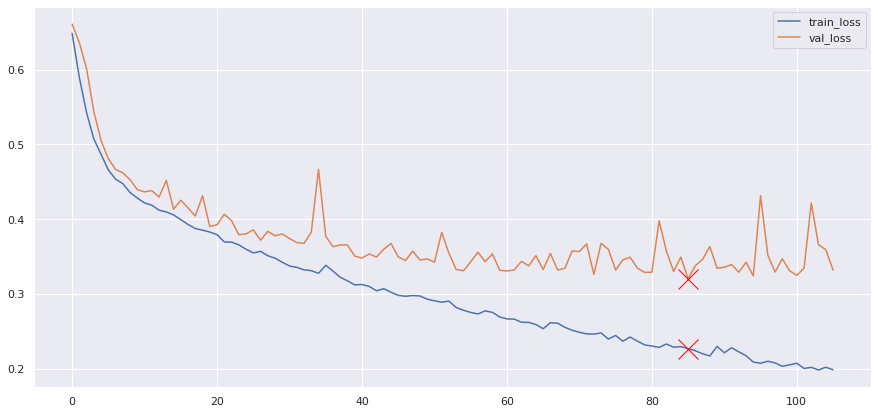

In [12]:
print("Smallest val loss is 【%s】. Corresponding val acc is 【%s】. Epoch is 【%s】" % (current_best_val_loss, current_that_val_acc, current_that_epoch))
plt.figure(figsize=(15,7))
that_epoch = current_that_epoch
plt.plot(train_loss_list, label="train_loss");
plt.plot(val_loss_list, label="val_loss");
plt.plot(that_epoch, train_loss_list[that_epoch], marker='x', color='red', markersize=20)
plt.plot(that_epoch, val_loss_list[that_epoch], marker='x', color='red', markersize=20)
plt.legend();

### 3.2 Hyperparameter Optimization (Too slow)

> This part needs a lot of time. So we just show the results.

Method: Random search

Parameters need to tune:
* learning rate for Adam: `[0.005,0.05]`
* activation function: sigmoid, ReLU, tanh
* dropout:`[0.2, 0.8]`

In [0]:
input_dim = train_set[0][0].shape[0]

each_how_many = 40
total_info = []


for act_func in ["sigmoid", "tanh", "relu"]:
    for i in range(each_how_many):
        model_name    = "Model_%s_%s" % (act_func, str(i))
        lr            = 0.005+(0.05-0.005)*np.random.random()
        drop_out_rate = 0.2+(0.8-0.2)*np.random.random()
        
        model     = Classifier(name=model_name, input_dim=input_dim, act_func=act_func, dr=drop_out_rate).cuda()
        loss      = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        num_epoch = 400
        TAL, TLL, VAL, VLL, current_best_val_loss, current_that_val_acc, current_that_epoch \
            = trigger_with_early_stopping(train_loader, val_loader, model, loss, optimizer, num_epoch, patience=20, save_model=False, delta=0.001, print_log=False)

        info = (model_name, lr, drop_out_rate, act_func, current_best_val_loss, current_that_val_acc, current_that_epoch)
        total_info.append(info)

In [0]:
hyper_opt = pd.DataFrame(total_info, columns=["model name", "learning rate", "dropout rate", "activation function", "best val loss", "corres val acc", "that epoch"])
hyper_opt

,model name,learning rate,dropout rate,activation function,best val loss,corres val acc,that epoch
0,Model_sigmoid_0,0.012730,0.256399,sigmoid,0.312850,0.855976,23
1,Model_sigmoid_1,0.025235,0.647295,sigmoid,0.462681,0.849108,51
2,Model_sigmoid_2,0.042408,0.413867,sigmoid,0.324958,0.857358,28
3,Model_sigmoid_3,0.029516,0.287871,sigmoid,0.309688,0.859536,26
4,Model_sigmoid_4,0.013945,0.220688,sigmoid,0.301015,0.870885,41
...,...,...,...,...,...,...,...
115,Model_relu_35,0.022794,0.359741,relu,0.291731,0.868289,26
116,Model_relu_36,0.024379,0.414113,relu,0.290637,0.867451,18
117,Model_relu_37,0.042861,0.489119,relu,0.293343,0.865818,22
118,Model_relu_38,0.041216,0.523304,relu,0.288356,0.868373,44


In [0]:
hyper_opt.iloc[hyper_opt["best val loss"].argmin()]

model name             Model_relu_34
learning rate             0.00867688
dropout rate                0.260069
activation function             relu
best val loss               0.283972
corres val acc              0.870927
that epoch                        22
Name: 114, dtype: object

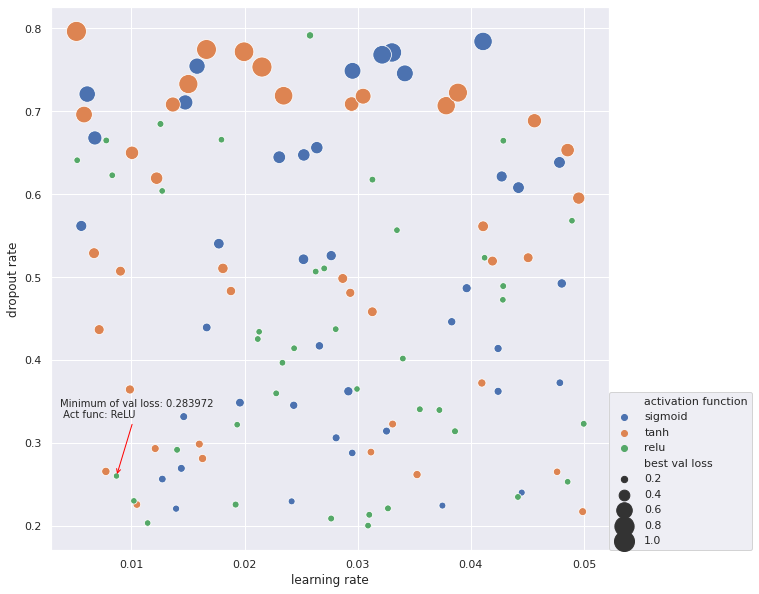

In [0]:
min_val_loss_lr = hyper_opt.iloc[hyper_opt["best val loss"].argmin()]["learning rate"]
min_val_loss_dr = hyper_opt.iloc[hyper_opt["best val loss"].argmin()]["dropout rate"]

plt.figure(figsize=(10,10))
sns.scatterplot(data=hyper_opt,
                x="learning rate", y="dropout rate", hue="activation function",
                size="best val loss",
                sizes=(40, 400),
                );
plt.annotate(s="Minimum of val loss: 0.283972\n Act func: ReLU", xy=(min_val_loss_lr, min_val_loss_dr), 
             xytext=(min_val_loss_lr-0.005, min_val_loss_dr+0.07),arrowprops={"arrowstyle":"->", "color":"red"}) 
plt.legend(loc=[1, 0]);

In [0]:
hyper_opt.to_csv("/content/myDrive/My Drive/Hotel_Cancellation/data/hyperparameter optimization results.csv", index=None)

Use the best combination to retrain the model on the whole training data (training set + validation set). Then, test it on the testing set.

In [0]:
class Classifier_mod(nn.Module):
    def __init__(self, name, input_dim, act_func="sigmoid", dr=0.5):
        super(Classifier_mod, self).__init__()
        self.name      = name
        self.input_dim = input_dim
        self.act_func  = act_func
        self.dr        = dr
        if act_func=="sigmoid":
            act_func_f = "nn.Sigmoid()"
        elif act_func=="tanh":
            act_func_f = "nn.Tanh()"
        elif act_func=="relu":
            act_func_f = "nn.ReLU()"
        else:
            raise Exception
        self.fc1 = nn.Sequential(
            #################
            nn.Linear(input_dim, 1000),
            nn.BatchNorm1d(1000),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(1000, 500),
            nn.BatchNorm1d(500),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(500, 250),
            nn.BatchNorm1d(250),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(250, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(100, 20),
            nn.BatchNorm1d(20),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(p=dr),
            eval(act_func_f),
            #################
            nn.Linear(20, 2),
        )
    def forward(self, x):
        x = self.fc1(x)
        self.hidden_output = x.detach()
        return self.fc2(x)

In [0]:
batch_size   = 6000
# Train set + Val set
X_train_all      = np.concatenate([X_train, X_val], axis=0)
y_train_all      = np.concatenate([y_train, y_val])
train_all_set    = HotelDataset(X_train_all, y_train_all)
train_all_loader = DataLoader(train_all_set, batch_size=batch_size, shuffle=True)

In [15]:
input_dim = train_all_set[0][0].shape[0]
model_name = "final_ann_model_mod"
dr         = 0.260069
lr         = 0.00867688

model     = Classifier_mod(model_name, input_dim, "relu", dr).cuda()
loss      = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)
num_epoch = 400
train_acc_list, train_loss_list, val_acc_list, val_loss_list, \
    current_best_val_loss, current_that_val_acc, current_that_epoch \
    = trigger_with_early_stopping(train_all_loader, test_loader, model, loss, optimizer, num_epoch, patience=20, save_model=True, delta=0)
print("Smallest test loss is 【%s】. Corresponding test acc is 【%s】" % (current_best_val_loss, current_that_val_acc))

*************************************************************************************
[Model: final_ann_model_mod] | [Act_func: relu] | [LR: 0.00867688] | [DR: 0.260069]
[001/400] 4.21 sec(s) Train Acc: 0.639595 Loss: 0.608797 | Val Acc: 0.677527 loss: 0.862383
[002/400] 2.81 sec(s) Train Acc: 0.813123 Loss: 0.419528 | Val Acc: 0.773222 loss: 0.618097
[003/400] 2.63 sec(s) Train Acc: 0.837968 Loss: 0.352179 | Val Acc: 0.833906 loss: 0.356150
[004/400] 2.61 sec(s) Train Acc: 0.848187 Loss: 0.330778 | Val Acc: 0.845883 loss: 0.334042
[005/400] 2.55 sec(s) Train Acc: 0.854919 Loss: 0.315786 | Val Acc: 0.853254 loss: 0.310083
[006/400] 2.58 sec(s) Train Acc: 0.860269 Loss: 0.304391 | Val Acc: 0.857191 loss: 0.304679
[007/400] Early-Stopping counter: 1 out of 20
[007/400] 2.49 sec(s) Train Acc: 0.861326 Loss: 0.303394 | Val Acc: 0.826409 loss: 0.354081
[008/400] 2.46 sec(s) Train Acc: 0.865389 Loss: 0.295350 | Val Acc: 0.863891 loss: 0.295448
[009/400] Early-Stopping counter: 1 out of 20
[0

Smallest test loss is 【0.2788882777094841】. Corresponding test acc is 【0.8728536728369211】. Epoch is 【22】


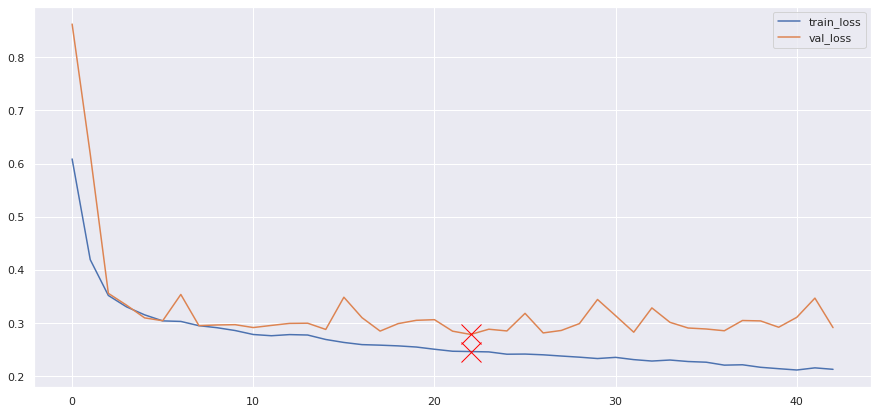

In [16]:
print("Smallest test loss is 【%s】. Corresponding test acc is 【%s】. Epoch is 【%s】" % (current_best_val_loss, current_that_val_acc, current_that_epoch))
plt.figure(figsize=(15,7))
that_epoch = current_that_epoch
plt.plot(train_loss_list, label="train_loss");
plt.plot(val_loss_list, label="val_loss");
plt.plot(that_epoch, train_loss_list[that_epoch], marker='x', color='red', markersize=20)
plt.plot(that_epoch, val_loss_list[that_epoch], marker='x', color='red', markersize=20)
plt.legend();

In [0]:
y_test_pred = np.array([])

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        x = data[0].float()
        y = data[1]
        pred = model(x.cuda())
        pre_label  = np.argmax(pred.cpu().data.numpy(), axis=1)
        y_test_pred = np.concatenate([y_test_pred, pre_label])

In [0]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     15033
           1       0.84      0.79      0.82      8845

    accuracy                           0.87     23878
   macro avg       0.86      0.85      0.86     23878
weighted avg       0.87      0.87      0.87     23878



### 3.3 Explainable Deep Learning Model

In [0]:
############ Path Settings ############
model_path = '/content/myDrive/My Drive/Hotel_Cancellation/model'
#######################################

ann_model_mod = Classifier_mod("ann_model_mod", input_dim, "relu", dr=0.260069).cuda()
ann_model_mod.load_state_dict(torch.load(os.path.join(model_path, "final_ann_model_mod.pt")))
ann_model_mod = ann_model_mod.cuda()

In [20]:
ind = 21
print("************************")
print("The [%sth] test instance: %s" % (ind, X_test_df.values[ind,:]))
print("************************")
print("The true label is [%s]" % y_test[ind])

ann_model_mod.eval()
with torch.no_grad():
    x = torch.tensor(X_test[ind].reshape(1,-1))
    pred = ann_model_mod(x.cuda())
    pre_label  = np.argmax(pred.cpu().data.numpy(), axis=1)
print("************************")
p0 = nn.functional.softmax(pred, dim=1).cpu().numpy()[0][0]
p1 = nn.functional.softmax(pred, dim=1).cpu().numpy()[0][1]
print("Predicted probability distribution: [0] %s, [1] %s" % (p0, p1))
print("************************")
print("The predicted label is [%s]" % pre_label[0])
print("************************")

************************
The [21th] test instance: ['City Hotel' 283 'July' 31 27 1 1 3 0.0 0 'BB' 'PRT' 'Groups' 'TA/TO' 0 1
 0 'A' 'A' 1 'Non Refund' 1.0 nan 0 'Transient-Party' 84.0 0 0]
************************
The true label is [1]
************************
Predicted probability distribution: [0] 2.3705148e-05, [1] 0.9999763
************************
The predicted label is [1]
************************


In [21]:
X_test_df.iloc[ind,:]

hotel                                  City Hotel
lead_time                                     283
arrival_date_month                           July
arrival_date_week_number                       31
arrival_date_day_of_month                      27
stays_in_weekend_nights                         1
stays_in_week_nights                            1
adults                                          3
children                                        0
babies                                          0
meal                                           BB
country                                       PRT
market_segment                             Groups
distribution_channel                        TA/TO
is_repeated_guest                               0
previous_cancellations                          1
previous_bookings_not_canceled                  0
reserved_room_type                              A
assigned_room_type                              A
booking_changes                                 1


So we want to know, why this model predict this instance as a positive sample——**LIME: Local Interpretable Model-agnostic Explanations**

In [22]:
# Step 1: Sample nearby
samples_nearby = np.zeros((5000, input_dim))
rng = np.random.RandomState(0)
for i in range(5000):
    temp = []
    temp.append(rng.choice(range(270,300)))    # lead time 
    temp.append(rng.choice(range(0,3)))        # stays_in_weekend_nights
    temp.append(rng.choice(range(0,3)))        # stays_in_week_nights
    temp.append(rng.choice(range(1,5)))        # adults
    temp.append(rng.choice(range(0,3)))        # children
    temp.append(rng.choice(range(0,3)))        # babies
    temp.append(rng.choice(range(0,3)))        # previous_cancellations
    temp.append(rng.choice(range(0,3)))        # previous_bookings_not_canceled
    temp.append(rng.choice(range(0,3)))        # booking_changes
    temp.append(rng.choice(range(0,8)))        # days_in_waiting_list
    temp.append(rng.choice(range(70,95)))     # adr
    temp.append(rng.choice(range(0,2)))        # required_car_parking_spaces
    temp.append(rng.choice(range(0,2)))        # total_of_special_requests
    temp += list(X_test[4, len(col_num):])
    samples_nearby[i] = temp

# Step 2: Get y
ann_model_mod.eval()
with torch.no_grad():
    x    = torch.tensor(samples_nearby).float()
    pred = ann_model_mod(x.cuda())
    pred_prob = nn.functional.softmax(pred, dim=1) 
pred_prob = pred_prob.cpu().numpy()
y_samples_nearby  = np.argmax(pred_prob, axis=1)
print(y_samples_nearby.sum())

# Step 3: Fit a linear model and explain it
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=3000)
lr.fit(samples_nearby, y_samples_nearby)
print(lr.score(samples_nearby, y_samples_nearby))

3551
0.9954


In [0]:
for i,j in enumerate(lr.coef_[0][:13]):
    print("%s: %s" % (col_num[i], round(j,2)))

lead_time: 0.0
stays_in_weekend_nights: 0.16
stays_in_week_nights: 0.17
adults: 0.39
children: 0.22
babies: 0.8
previous_cancellations: 6.31
previous_bookings_not_canceled: -0.5
booking_changes: -1.01
days_in_waiting_list: 0.03
adr: 0.03
required_car_parking_spaces: -13.9
total_of_special_requests: -1.93
